# IPO Exercise

### Exercise Description
You will work with a dataset of historical IPO information and build a model to predict first-
quarter performance. This exercise evaluates your ability to:

- Perform exploratory data analysis
- Handle real-world financial data issues
- Build and evaluate appropriate ML models
- Communicate findings to non-technical stakeholders

### Data Description
#### Company Metrics:
- company_age: Years since company founding
- employees: Number of employees at IPO
- revenue_millions: Annual revenue in millions USD
- revenue_growth_rate: YoY revenue growth percentage
- ebitda_margin: EBITDA margin percentage
- industry_sector: Tech, Healthcare, Finance, Consumer, Industrial, Energy
#### IPO Characteristics:
- offer_price: Initial offering price per share
- shares_offered_millions: Number of shares offered
- underwriter_rank: Prestige ranking of lead underwriter (1-10)
- venture_backed: Binary indicator (0/1)
- lockup_period_days: Days until insiders can sell shares
#### Market Conditions:
- market_volatility_index: VIX level at IPO date
- sector_performance_30d: Sector index performance prior 30 days (%)
- ipo_month: Month of IPO (1-12)
#### Target Variable:
- q1_return: First quarter stock return (%) - YOUR PREDICTION TARGET

**Binary classification:** 1 if return > 0%, 0 otherwise
**Dataset size:** ~400 companies, ~20% missing values in some features

## 1. generate mock dataset 

In [1]:
# import pandas as pd
# import numpy as np
# np.random.seed(42)
# n_samples = 400
# # Generate synthetic IPO data
# data = {
# 'company_age': np.random.exponential(8, n_samples),
# 'employees': np.random.lognormal(6, 1.5, n_samples),
# 'revenue_millions': np.random.lognormal(4, 1.8, n_samples),
# 'revenue_growth_rate': np.random.normal(30, 25, n_samples),
# 'ebitda_margin': np.random.normal(-5, 15, n_samples),
# 'industry_sector': np.random.choice(['Tech', 'Healthcare', 'Finance', 'Consumer', 'Industrial', 'Energy'],
# n_samples),
# 'offer_price': np.random.lognormal(2.5, 0.6, n_samples),
# 'shares_offered_millions': np.random.lognormal(2, 1, n_samples),
# 'underwriter_rank': np.random.randint(1, 11, n_samples),
# 'venture_backed': np.random.binomial(1, 0.6, n_samples),
# 'lockup_period_days': np.random.choice([90, 180, 270, 365], n_samples),
# 'market_volatility_index': np.random.normal(18, 6, n_samples),
# 'sector_performance_30d': np.random.normal(2, 8, n_samples),
# 'ipo_month': np.random.randint(1, 13, n_samples),
# }
# df = pd.DataFrame(data)
# # Create target with some signal
# score = (
# df['revenue_growth_rate'] * 0.02 +
# df['underwriter_rank'] * 0.15 +
# df['venture_backed'] * 0.3 -
# df['market_volatility_index'] * 0.05 +
# df['sector_performance_30d'] * 0.08 +
# np.random.normal(0, 1, n_samples))
# df['q1_return'] = (score > score.median()).astype(int)
# # Add missing values
# missing_mask = np.random.random(df.shape) < 0.1
# df = df.mask(missing_mask)
# df.to_csv('ipo_data.csv', index=False)

## 2. import libraries

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report, RocCurveDisplay)

# random state
RANDOM_STATE = 42

## 3. load dataset

In [3]:
df = pd.read_csv('ipo_data.csv')
df.head()

,company_age,employees,revenue_millions,revenue_growth_rate,ebitda_margin,industry_sector,offer_price,shares_offered_millions,underwriter_rank,venture_backed,lockup_period_days,market_volatility_index,sector_performance_30d,ipo_month,q1_return
0,3.754145,2858.974322,51.022032,NaN,-6.240210,Finance,12.950233,19.605629,3.0,1.0,270.0,11.141884,-10.300678,6.0,0.0
1,NaN,416.341469,397.797622,39.124025,-6.826213,Finance,30.858495,18.512653,10.0,1.0,365.0,22.920949,0.840763,5.0,1.0
2,10.533966,1122.068860,67.061477,90.085390,NaN,Healthcare,NaN,2.126086,3.0,0.0,180.0,NaN,-1.567550,2.0,1.0
3,7.303540,253.306411,71.560495,28.559530,4.462175,Healthcare,NaN,7.806324,8.0,1.0,270.0,18.437245,2.905124,NaN,1.0
4,NaN,656.058216,28.374703,35.027476,-20.362802,Industrial,13.448351,3.634313,8.0,0.0,180.0,18.439182,-0.904933,10.0,1.0


## 4. EDA

In [4]:
# shape
print(df.shape)
# info
df.info()
# stats
df.describe().T

(400, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   company_age              361 non-null    float64
 1   employees                354 non-null    float64
 2   revenue_millions         362 non-null    float64
 3   revenue_growth_rate      363 non-null    float64
 4   ebitda_margin            362 non-null    float64
 5   industry_sector          353 non-null    object 
 6   offer_price              366 non-null    float64
 7   shares_offered_millions  362 non-null    float64
 8   underwriter_rank         352 non-null    float64
 9   venture_backed           356 non-null    float64
 10  lockup_period_days       372 non-null    float64
 11  market_volatility_index  371 non-null    float64
 12  sector_performance_30d   353 non-null    float64
 13  ipo_month                365 non-null    float64
 14  q1_return       

,count,mean,std,min,25%,50%,75%,max
company_age,361.0,7.684239,7.235721,0.044299,2.277290,5.728746,10.626349,37.256039
employees,354.0,1277.792643,3031.860442,7.061589,149.924876,397.359168,1116.948857,40876.933616
revenue_millions,362.0,290.938160,700.708134,0.297227,20.873685,76.271702,208.912158,6237.206699
revenue_growth_rate,363.0,32.291675,25.232133,-34.776057,13.646860,32.045734,48.462164,95.042078
ebitda_margin,362.0,-4.770398,14.715656,-48.820257,-14.301445,-5.379510,5.083979,42.896614
offer_price,366.0,14.780041,9.980470,2.553517,8.210021,12.329693,18.337643,78.724242
shares_offered_millions,362.0,12.766320,23.278855,0.473547,3.832836,7.152591,14.419425,374.741969
underwriter_rank,352.0,5.630682,2.854490,1.000000,3.000000,6.000000,8.000000,10.000000
venture_backed,356.0,0.632022,0.482934,0.000000,0.000000,1.000000,1.000000,1.000000
lockup_period_days,372.0,225.000000,103.038082,90.000000,90.000000,270.000000,270.000000,365.000000


### missing data

In [5]:
df_missing = df.isnull().mean().sort_values(ascending=False)
df_missing

underwriter_rank           0.1200
sector_performance_30d     0.1175
industry_sector            0.1175
q1_return                  0.1175
employees                  0.1150
venture_backed             0.1100
company_age                0.0975
shares_offered_millions    0.0950
revenue_millions           0.0950
ebitda_margin              0.0950
revenue_growth_rate        0.0925
ipo_month                  0.0875
offer_price                0.0850
market_volatility_index    0.0725
lockup_period_days         0.0700
dtype: float64

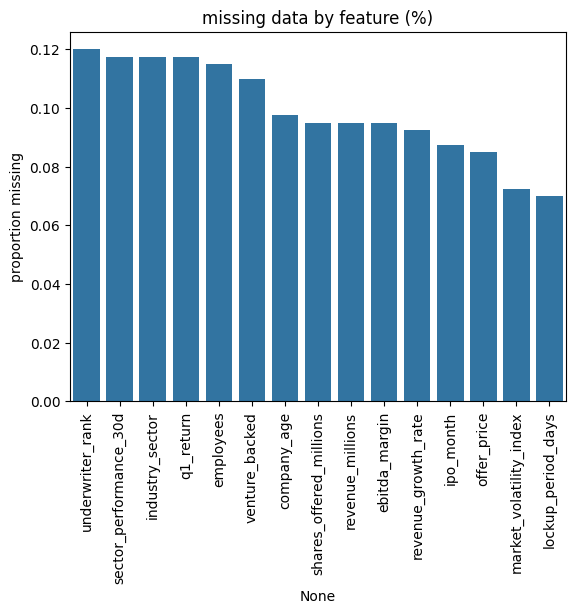

In [6]:
sns.barplot(x=df_missing.index, y=df_missing.values)
plt.xticks(rotation=90)
plt.title("missing data by feature (%)")
plt.ylabel("proportion missing")
plt.show()

**observation:**
- all fields contain missing data incl. the target label (q1_return) -> too few records to drop missing records - impute for numerical and categorical features, drop missing records for target - can't train without target
- missing data ranges from 7-12%

### industry sector analysis

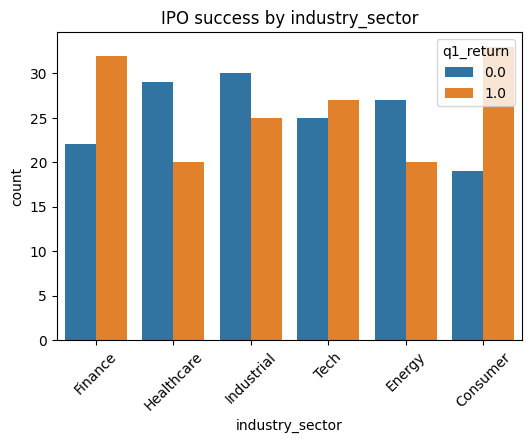

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(x='industry_sector', hue='q1_return', data=df)
plt.title("IPO success by industry_sector")
plt.xticks(rotation=45)
plt.show()

- Finance and Consumer sectors have relatively more successful IPOs in Q1

### target balance

In [8]:
target = 'q1_return'

df[target].value_counts(normalize=True)

q1_return
0.0    0.501416
1.0    0.498584
Name: proportion, dtype: float64

**observation:**
- data is balanced ~50/50 - no need to balance dataset

### distribution

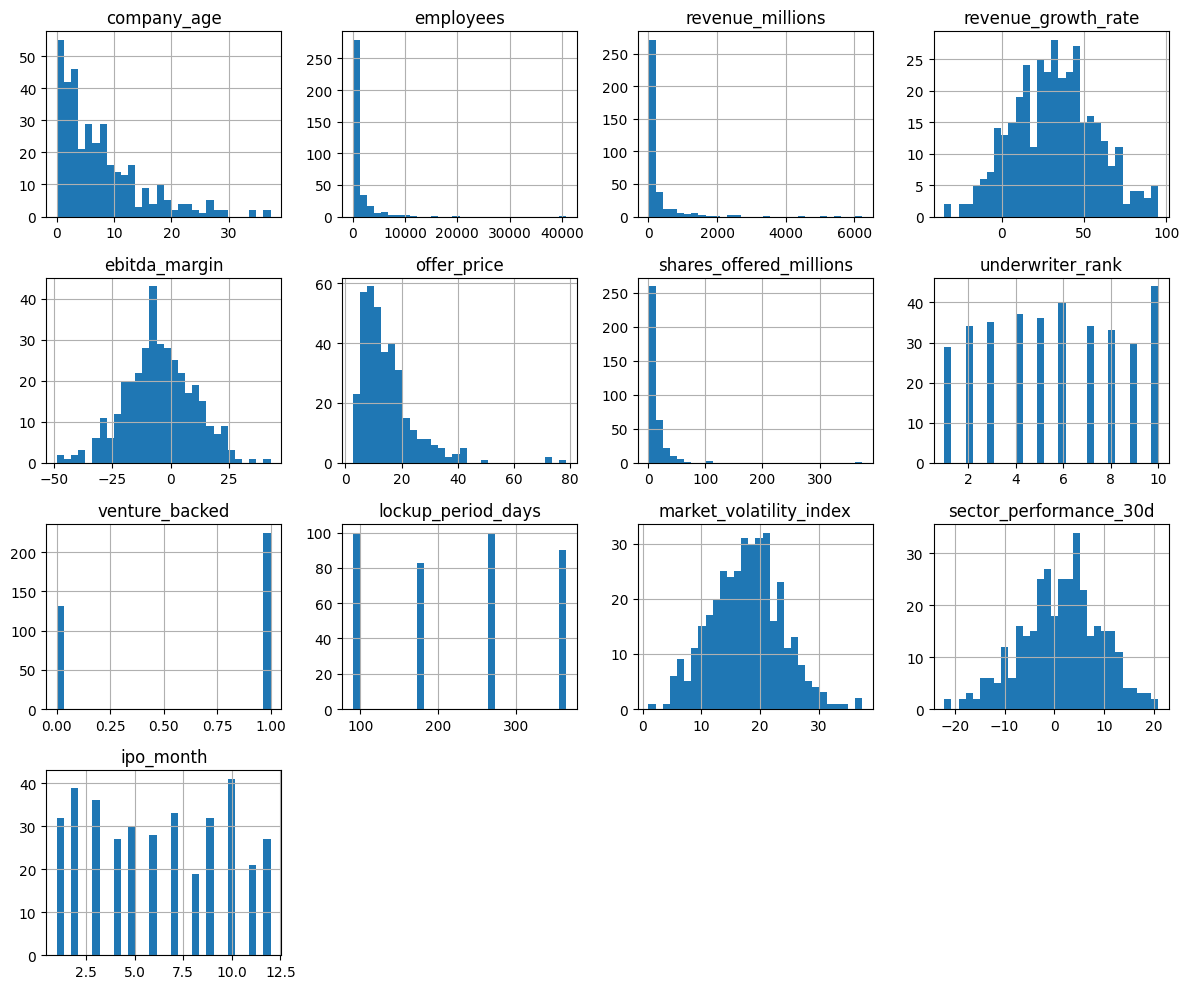

In [9]:
# numerical cols
numeric_cols = [c for c in df.drop(target, axis=1) if df[c].dtype != 'object']

# visualise distrubution
df[numeric_cols].hist(bins=30, figsize=(12, 10))
plt.tight_layout()

**observation:**
- company_age, employees, revenue_millions, offer_price and shares_offered_millions are skewed - log transform skewed features to reduce skew
- lockup_period_days and venture_backed can be treated as categorical features

## 5. feature engineering

In [10]:
def feature_eng(df):
    df = df.copy()
    # log transform
    skewed_cols = ['company_age', 'employees', 'revenue_millions', 'offer_price', 'shares_offered_millions']
    for col in skewed_cols:
        df[f'log_{col}'] = np.log1p(df[col])

    # revenue per employee - capital productivity
    df['revenue_per_employee'] = df['revenue_millions'] / df['employees']

    # sector × volatility - risk sentiment
    df['sector_volatility'] = df['sector_performance_30d'] * df['market_volatility_index']
    
    # drop skewed features
    df = df.drop(skewed_cols, axis=1)

    # reorder cols
    df = df[[c for c in df.columns if c != 'q1_return']+['q1_return']]

    # drop missing target cols
    df = df.dropna(subset=['q1_return'])
    
    return df

In [11]:
df_input = feature_eng(df)

df_input.head()

,revenue_growth_rate,ebitda_margin,industry_sector,underwriter_rank,venture_backed,lockup_period_days,market_volatility_index,sector_performance_30d,ipo_month,log_company_age,log_employees,log_revenue_millions,log_offer_price,log_shares_offered_millions,revenue_per_employee,sector_volatility,q1_return
0,NaN,-6.240210,Finance,3.0,1.0,270.0,11.141884,-10.300678,6.0,1.559017,7.958568,3.951667,2.635496,3.025564,0.017846,-114.768965,0.0
1,39.124025,-6.826213,Finance,10.0,1.0,365.0,22.920949,0.840763,5.0,NaN,6.033905,5.988454,3.461304,2.971063,0.955460,19.271094,1.0
2,90.085390,NaN,Healthcare,3.0,0.0,180.0,NaN,-1.567550,2.0,2.445296,7.023820,4.220411,NaN,1.139782,0.059766,NaN,1.0
3,28.559530,4.462175,Healthcare,8.0,1.0,270.0,18.437245,2.905124,NaN,2.116682,5.538540,4.284421,NaN,2.175470,0.282506,53.562475,1.0
4,35.027476,-20.362802,Industrial,8.0,0.0,180.0,18.439182,-0.904933,10.0,NaN,6.487773,3.380134,2.670580,1.533488,0.043250,-16.686230,1.0


## 6. pipeline

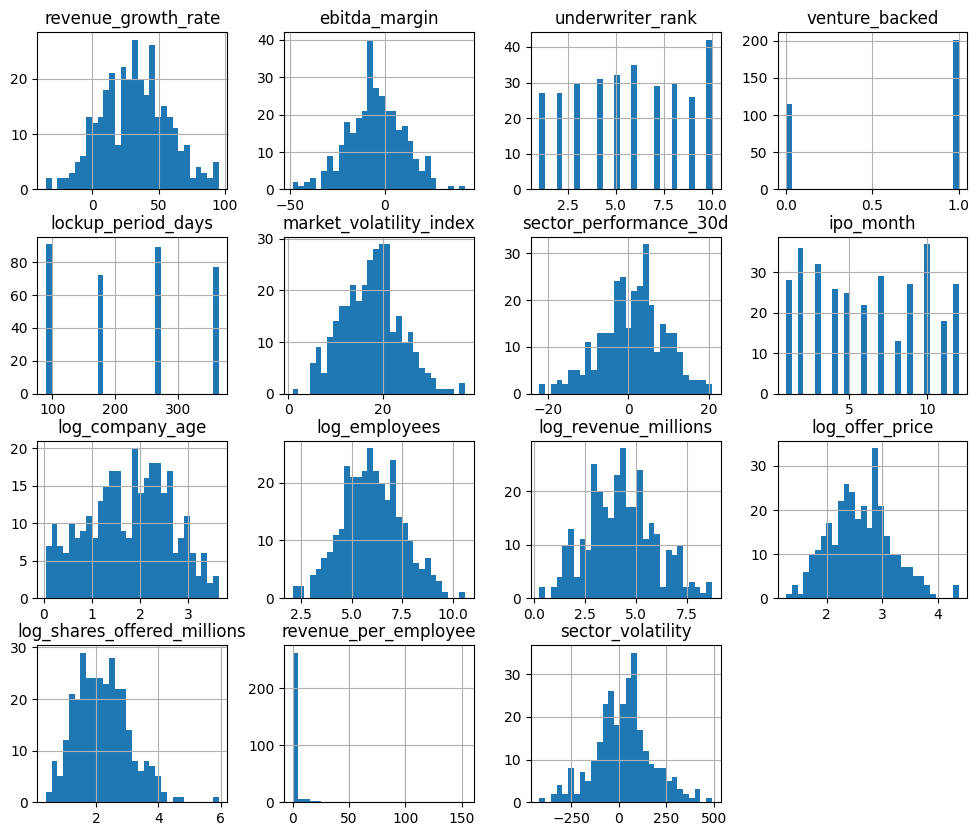

In [12]:
# numerical features
num_features = df_input.select_dtypes(include=[np.number]).columns.drop([target]).tolist()

# visualise updated distribution
df_input[num_features].hist(bins=30, figsize=(12,10));

- log transformed feature distribution are now less skewed

In [13]:
# categorical features
cat_features = ['industry_sector', 'lockup_period_days', 'venture_backed']

# update numerical features (excl. cat features)
num_features = [n for n in num_features if n not in cat_features]

In [14]:
# pipelines
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features),
])

## 7. build model

In [15]:
X = df_input.drop(target, axis=1)
y = df_input[target]

# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

### model pipeline

In [16]:
# Logistic pipeline
log_pipe = Pipeline([
    ('pre', preprocessor),
    ('log', LogisticRegression(random_state=RANDOM_STATE))
])
log_pipe.fit(X_train, y_train)

# Random Forest
rfc_pipe = Pipeline([
    ('pre', preprocessor),
    ('rfc', RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE))
])
rfc_pipe.fit(X_train, y_train);

## 8. evaluate metrics

--- Logistic Regression ---
Accuracy: 0.7605633802816901
ROC AUC: 0.830952380952381
Precision: 0.78125
Recall: 0.7142857142857143
F1: 0.746268656716418
              precision    recall  f1-score   support

         0.0       0.74      0.81      0.77        36
         1.0       0.78      0.71      0.75        35

    accuracy                           0.76        71
   macro avg       0.76      0.76      0.76        71
weighted avg       0.76      0.76      0.76        71



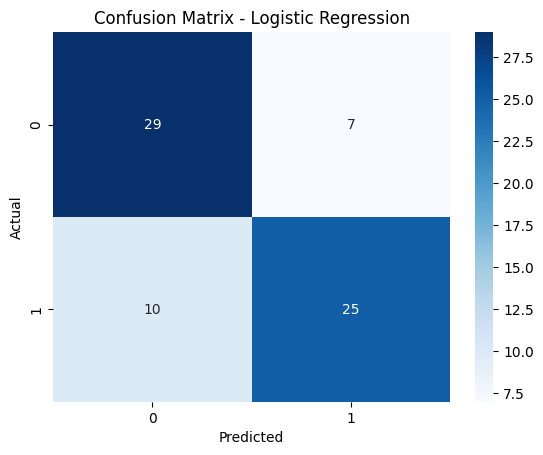

--- Random Forest ---
Accuracy: 0.7464788732394366
ROC AUC: 0.8253968253968254
Precision: 0.7931034482758621
Recall: 0.6571428571428571
F1: 0.71875
              precision    recall  f1-score   support

         0.0       0.71      0.83      0.77        36
         1.0       0.79      0.66      0.72        35

    accuracy                           0.75        71
   macro avg       0.75      0.75      0.74        71
weighted avg       0.75      0.75      0.74        71



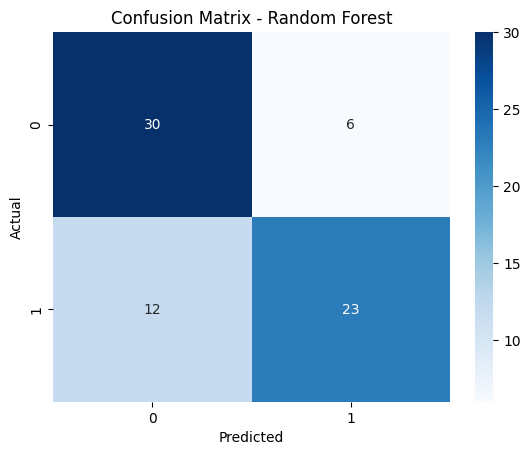

In [17]:
def evaluate_model(pipe, X_test, y_test, model_name):
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1] # get the positive return class only
    
    print(f"--- {model_name} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1:", f1_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
    
evaluate_model(log_pipe, X_test, y_test, "Logistic Regression")
evaluate_model(rfc_pipe, X_test, y_test, "Random Forest")

### ROC curve

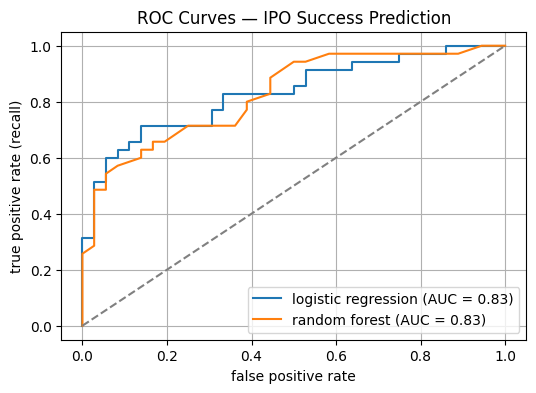

In [34]:
y_pred_proba_log = log_pipe.predict_proba(X_test)[:,1] # get the positive return class only
y_pred_proba_rfc = rfc_pipe.predict_proba(X_test)[:,1] # get the positive return class only
# Compute ROC curve and AUC
fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_proba_log)
fpr_rfc, tpr_rfc, _ = roc_curve(y_test, y_pred_proba_rfc)

auc_log = roc_auc_score(y_test, y_pred_proba_log)
auc_rfc = roc_auc_score(y_test, y_pred_proba_rfc)

# Plot ROC Curves
plt.figure(figsize=(6, 4))
plt.plot(fpr_log, tpr_log, label=f'logistic regression (AUC = {auc_log:.2f})')
plt.plot(fpr_rfc, tpr_rfc, label=f'random forest (AUC = {auc_rfc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate (recall)')
plt.title('ROC Curves — IPO Success Prediction')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

- Data is balanced so using the FPR in the ROC curve is appropriate
- ROC AUC is similar (83%), however Logistic regression is more stable

### cross-validation

In [18]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = ['accuracy','roc_auc','precision','recall','f1']

cv_results_log = cross_validate(log_pipe, X, y, cv=skf, scoring=scoring, return_train_score=True)
cv_results_rfc = cross_validate(rfc_pipe, X, y, cv=skf, scoring=scoring, return_train_score=True)

print(f'Logistic CV Results (mean):\n{pd.DataFrame(cv_results_log).mean()}')
print()
print(f'Random Forest CV Results (mean):\n{pd.DataFrame(cv_results_rfc).mean()}')

Logistic CV Results (mean):
fit_time           0.012921
score_time         0.019258
test_accuracy      0.716740
train_accuracy     0.796742
test_roc_auc       0.832027
train_roc_auc      0.881372
test_precision     0.714541
train_precision    0.800048
test_recall        0.733968
train_recall       0.789807
test_f1            0.718410
train_f1           0.794839
dtype: float64

Random Forest CV Results (mean):
fit_time           0.140068
score_time         0.025221
test_accuracy      0.691308
train_accuracy     1.000000
test_roc_auc       0.772254
train_roc_auc      1.000000
test_precision     0.696201
train_precision    1.000000
test_recall        0.682698
train_recall       1.000000
test_f1            0.684079
train_f1           1.000000
dtype: float64


- Random Forest clearly overfits the training data: test accuracy, precision and recall is significantly lower than the equivalent training metrics
- Random Forest has lower generalisation for all metrics

## 9. feature importance

#### logistic regression

In [19]:
# get numeric names
num_cols_after = num_features
# get onehot names
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
ohe_cols = list(ohe.get_feature_names_out(cat_features))
feature_names = num_cols_after + ohe_cols

coefs = log_pipe.named_steps['log'].coef_[0] # get feature coefficients
df_coef = pd.DataFrame({'feature': feature_names, 'coef': coefs}).sort_values(by='coef', key=abs, ascending=False)
df_coef['abs_coef'] = df_coef['coef'].abs()
df_coef.head(5) # top 5 features

,feature,coef,abs_coef
4,sector_performance_30d,1.108166,1.108166
0,revenue_growth_rate,0.993806,0.993806
3,market_volatility_index,-0.954525,0.954525
2,underwriter_rank,0.848197,0.848197
15,industry_sector_Healthcare,-0.542849,0.542849


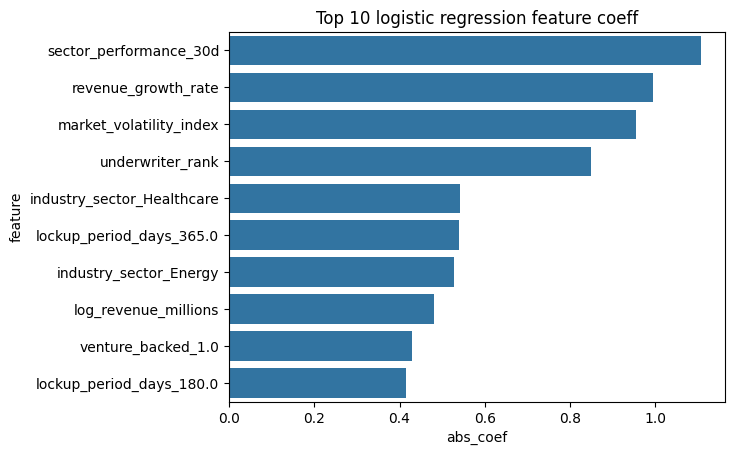

In [20]:
# bar plot
sns.barplot(data=df_coef.head(10), x='abs_coef', y='feature')
plt.title("Top 10 logistic regression feature coeff");

#### random forest

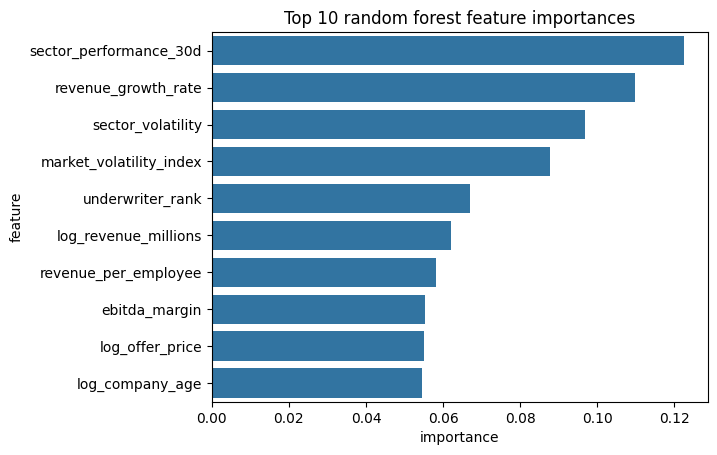

In [21]:
importances = rfc_pipe.named_steps['rfc'].feature_importances_ # feature importances
df_imp = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False)
# bar plot
sns.barplot(data=df_imp.head(10), x='importance', y='feature')
plt.title("Top 10 random forest feature importances");

## 10. business insights

## Business Insights & Summary

### Summary

This project predicts whether an IPO will be **successful (positive Q1 return)** using both firm-level fundamentals and market context (industry, volatility, underwriter reputation, etc.).

**Model Performance:**
- Logistic Regression is robust (ROC AUC 83%, Accuracy 76%, F1 score 75%)
- Random Forest overfits -> less reliable for real-world prediction (Accuracy: train = 100%, test ≈ 69%)

**Key Drivers of Q1 returns:**
1. Sector performance -> strong predictor; sectors with positive recent performance produce better IPO outcomes
2. Revenue growth rate -> fast-growing companies perform better post-IPO 
3. Market volatility (negative impact) -> high volatility decreases probability of positive Q1 returns
4. Underwriter rank -> top underwriters correlate with stronger IPO performance

The model offers **strong explanatory value**, confirming that **sector momentum, market conditions, and underwriter reputation** strongly influence IPO outcomes.

---

### Recommendations

- Use Logistic Regression to prioritise IPO allocation or underwriting decisions
- Focus on IPOs in high-performing sectors, high revenue growth, moderate volatility, and reputable underwriters
- Consider adding macroeconomic or investor sentiment features for future improvements

---

### Limitations:

- Moderate dataset size (400 IPOs) -> may limit generalisation
- Missing data imputed -> potential bias
- External market shocks or regulatory changes not captured

---

### Model Comparison Summary:

| **Model** | **Accuracy** | **ROC AUC** | **Precision** | **Recall** | **F1** | **CV AUC** | **Observation** |
|------------|--------------|--------------|---------------|-------------|---------|-------------|----------------|
| **Logistic Regression** | 0.76 | 0.83 | 0.78 | 0.71 | 0.75 | 0.83 | Best generalisation and interpretability |
| **Random Forest** | 0.75 | 0.83 | 0.79 | 0.66 | 0.72 | 0.77 | Overfitting detected; less robust for small data |

---

### Key Takeaways:

- Logistic Regression is reliable and interpretable for Q1 return prediction
- Sector performance and revenue growth are the strongest predictors
- Risk and underwriter quality significantly influence early IPO outcomes
- Model can guide IPO selection but should complement broader investment analysis